In [1]:
# Reference: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
import pandas as pd
from sklearn.model_selection import train_test_split

import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

2023-06-13 20:00:52.130045: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Get BERT model
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1'
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [9]:
# Build the model
def build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess):
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [10]:
# Compile the model
def compile_model(classifier_model, train_ds, lr = 3e-6, epoch = 10):
    # model fine tuning
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    epochs = 10
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=lr,
                                              num_train_steps=num_train_steps,
                                              num_warmup_steps=num_warmup_steps,
                                              optimizer_type='adamw')

    classifier_model.compile(optimizer=optimizer,
                             loss=loss,
                             metrics=metrics)
    return classifier_model

In [11]:
# Prepare dataset
def prepare_data(dataset):
    # Load the dataset
    df = pd.read_csv(f'../dataset/{dataset}', encoding='utf-8').dropna()
    df.columns = ['label', 'text']

    # Use sklearn to split the dataset into training, validating and testing
    train_df, val_df = train_test_split(df, test_size=0.3, random_state=42)
    val_df, test_df = train_test_split(val_df, test_size=0.33, random_state=24)

    # Create training dataset
    AUTOTUNE = tf.data.AUTOTUNE
    batch_size = 32

    train_ds = tf.data.Dataset.from_tensor_slices(
        (train_df['text'].values, train_df['label'].values)
    )
    train_ds = train_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

    # Create validation dataset
    val_ds = tf.data.Dataset.from_tensor_slices(
        (val_df['text'].values, val_df['label'].values)
    )
    val_ds = val_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)

    # Create testing dataset
    test_ds = tf.data.Dataset.from_tensor_slices(
        (test_df['text'].values, test_df['label'].values)
    )
    test_ds = test_ds.batch(batch_size).cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_ds, val_ds, test_ds


In [12]:
# Show result
def evaluate_model(test_ds):
    # Evaluate performance
    loss, accuracy = classifier_model.evaluate(test_ds)

    print(f'Loss: {loss}')
    print(f'Accuracy: {accuracy}')
    
def show_history(history):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict['binary_accuracy']
    val_acc = history_dict['val_binary_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

In [13]:
# Build a compile a global model for reuse
model = build_classifier_model(tfhub_handle_encoder, tfhub_handle_preprocess)

Epoch 1/10
443/443 [==============================] - 83s 167ms/step - loss: 0.4825 - binary_accuracy: 0.7804 - val_loss: 0.3441 - val_binary_accuracy: 0.8433
Epoch 2/10
443/443 [==============================] - 74s 166ms/step - loss: 0.3021 - binary_accuracy: 0.8691 - val_loss: 0.2621 - val_binary_accuracy: 0.8940
Epoch 3/10
443/443 [==============================] - 74s 166ms/step - loss: 0.2514 - binary_accuracy: 0.8955 - val_loss: 0.2386 - val_binary_accuracy: 0.9033
Epoch 4/10
443/443 [==============================] - 83s 187ms/step - loss: 0.2339 - binary_accuracy: 0.9035 - val_loss: 0.2296 - val_binary_accuracy: 0.9100
Epoch 5/10
443/443 [==============================] - 74s 166ms/step - loss: 0.2220 - binary_accuracy: 0.9104 - val_loss: 0.2241 - val_binary_accuracy: 0.9127
Epoch 6/10
443/443 [==============================] - 83s 186ms/step - loss: 0.2172 - binary_accuracy: 0.9117 - val_loss: 0.2191 - val_binary_accuracy: 0.9164
Epoch 7/10
443/443 [==========================

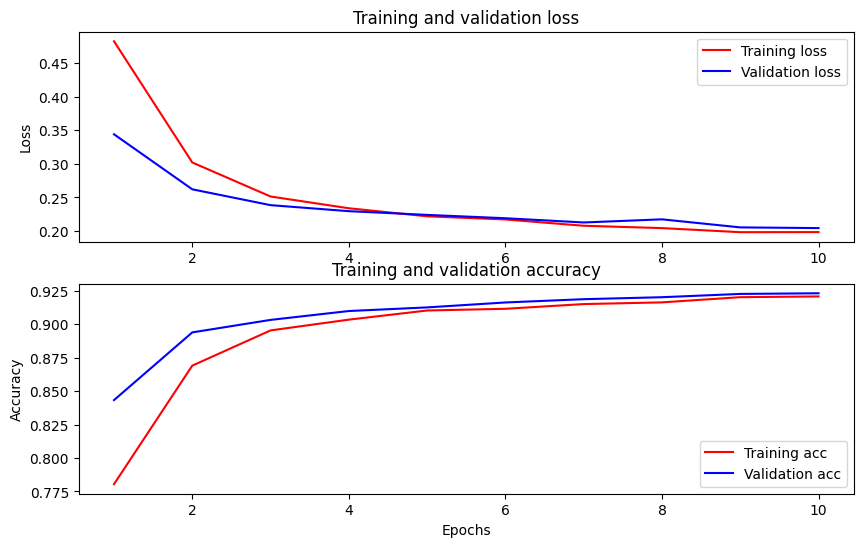

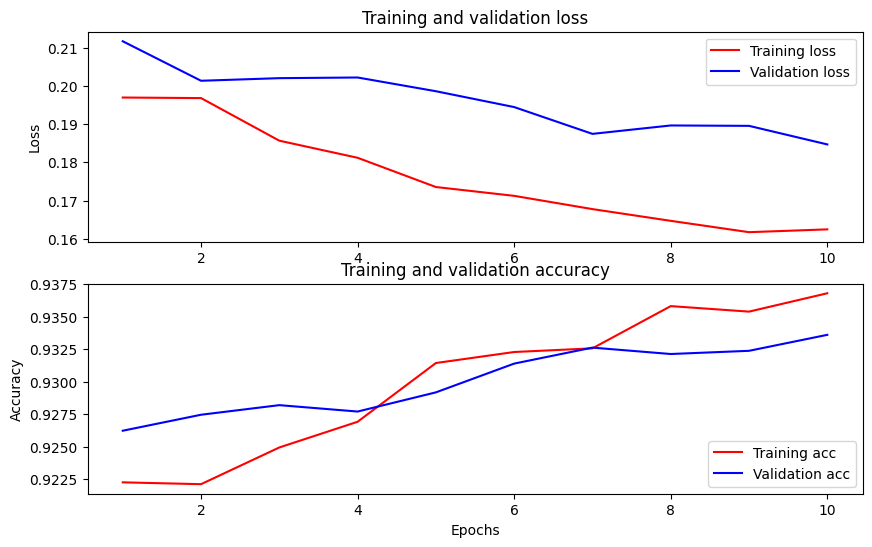

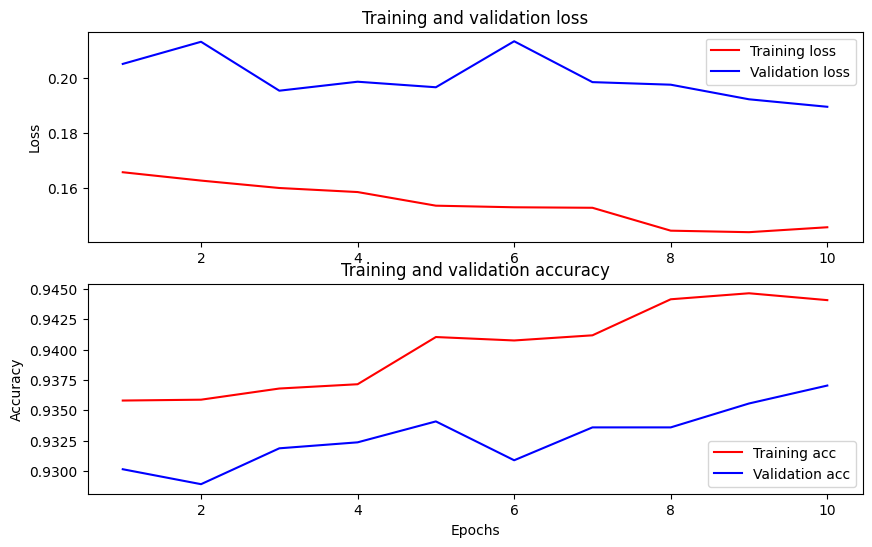

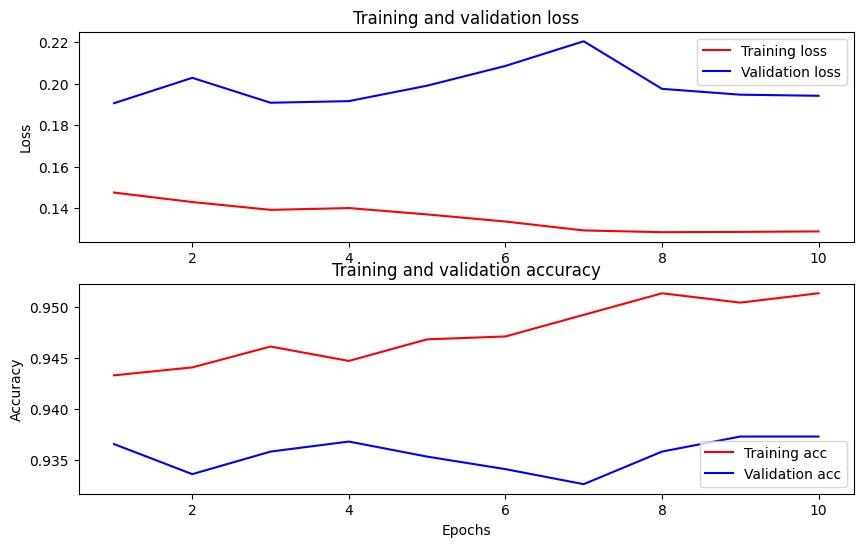

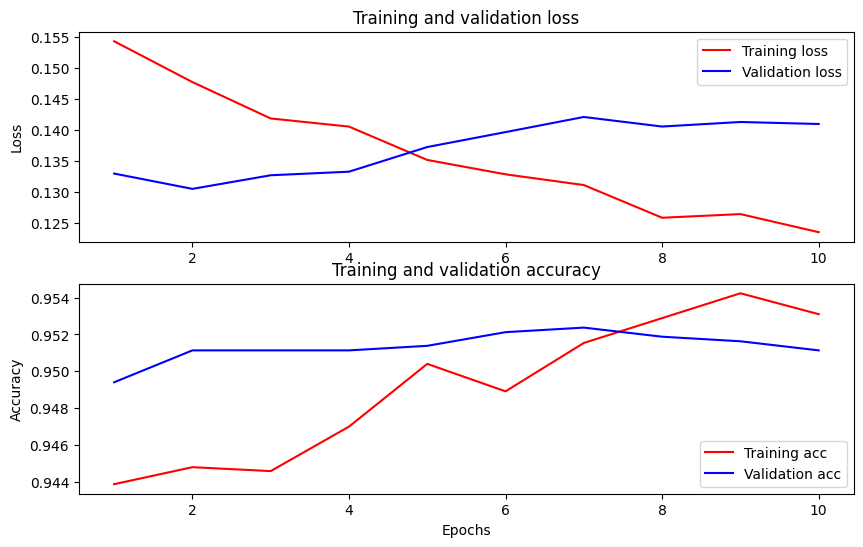

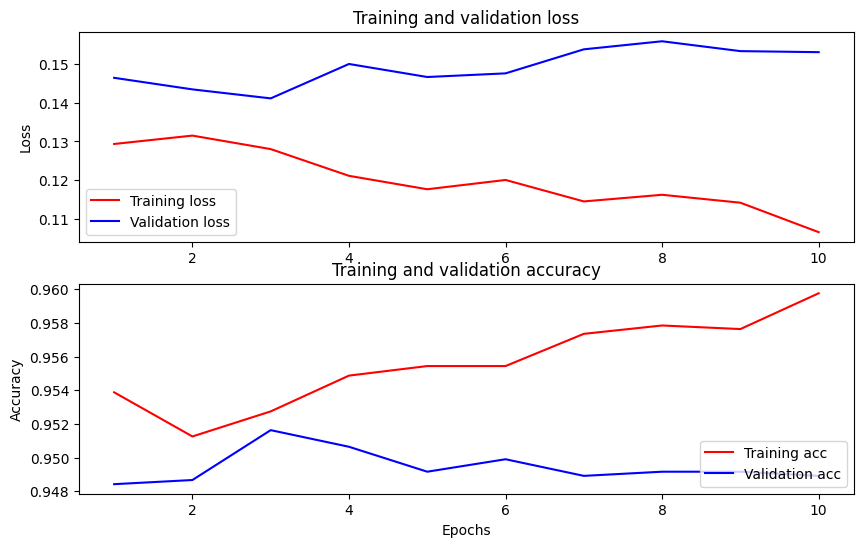

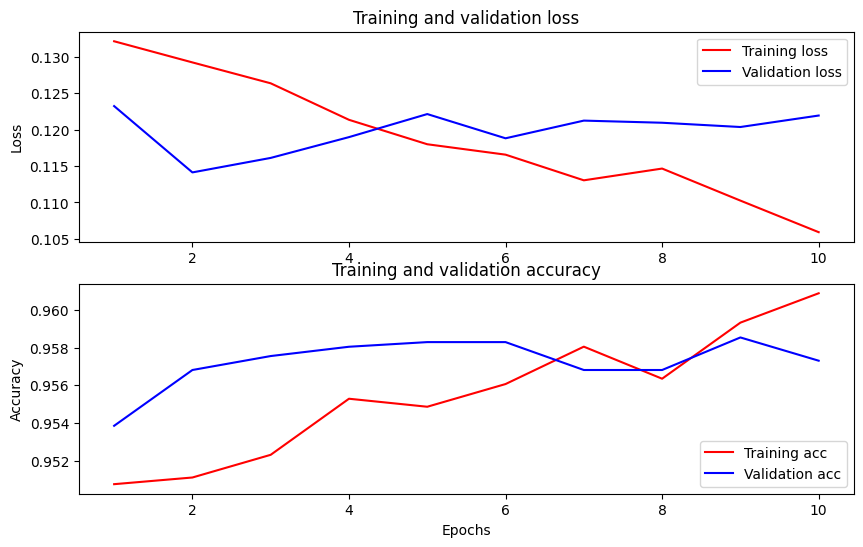

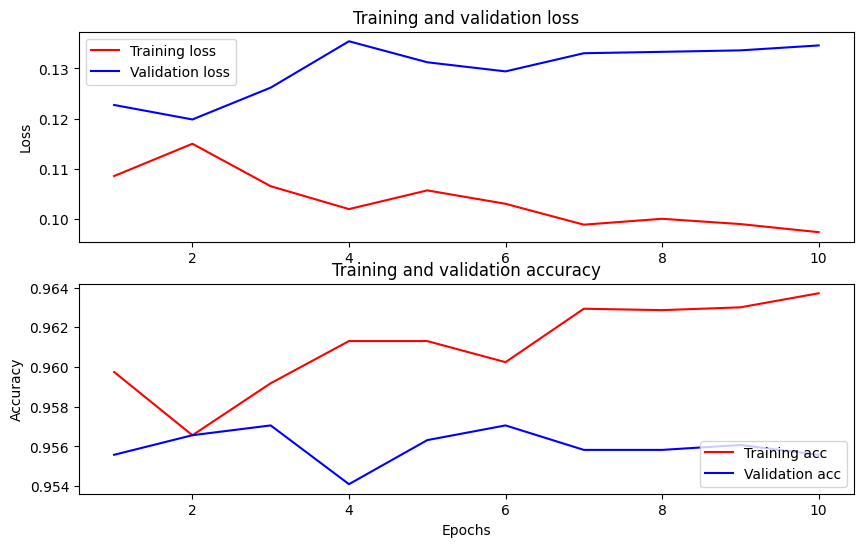

In [15]:
# Try performance on different dataset

# Define list of dataset
datasets = [
    'set_01_02_03_04_0_0_0_new.csv',
    'set_01_02_03_04_0_0_1_new.csv',
    'set_01_02_03_04_0_1_0_new.csv',
    'set_01_02_03_04_0_1_1_new.csv',
    'set_01_02_03_04_1_0_0_new.csv',
    'set_01_02_03_04_1_0_1_new.csv',
    'set_01_02_03_04_1_1_0_new.csv',
    'set_01_02_03_04_1_1_1_new.csv'
]

for dataset in datasets:
    train_ds, val_ds, test_ds = prepare_data(dataset)
    classifier_model = compile_model(model, train_ds)
    history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=10)
    evaluate_model(test_ds)
    show_history(history)

In [25]:
# Save the model
classifier_model.save('saved_model/bertSmsClassifier')